In [29]:
import numpy as np
import pandas as pd
import seaborn as sns
import time
import pickle

import scipy
from scipy.stats import chi2_contingency, mannwhitneyu

import sklearn
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.feature_selection import SelectFromModel,SelectKBest, RFE, f_classif, mutual_info_classif
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_curve, auc
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import VotingClassifier
from sklearn import svm

import matplotlib.pyplot as plt
%matplotlib inline

# Formatting

In [30]:
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('pdf', 'png')
plt.rcParams['savefig.dpi'] = 75

plt.rcParams['figure.autolayout'] = False
plt.rcParams['figure.figsize'] = (7, 5)
plt.rcParams['axes.labelsize'] = 18
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['font.size'] = 16
plt.rcParams['lines.linewidth'] = 2.0
plt.rcParams['lines.markersize'] = 8
plt.rcParams['legend.fontsize'] = 14

plt.rcParams['text.usetex'] = False
plt.rcParams['font.family'] = "sans-serif"
plt.rcParams['font.serif'] = "cm"
plt.rcParams['text.latex.preamble'] = "\\usepackage{subdepth} \\usepackage{type1cm}"

# Functions

In [31]:
def t_score(X, y):
    X0 = X[y == 0]
    X1 = X[y == 1]
    
    mu0 = np.mean(X0, axis = 0)
    mu1 = np.mean(X1, axis = 0)
    
    s0 = np.std(X0, axis = 0)
    s1 = np.std(X1, axis = 0)
    
    return np.abs(mu0 - mu1)/(s0 + s1)

def z_score(X):
    mu = np.mean(X, axis = 0)
    s = np.std(X, axis = 0)
    
    return (X - mu)/s

def mwu_score(X, y):
    m, n = X.shape
    
    score = np.zeros(n)
    for i in range(n):
        score[i] = scipy.stats.mannwhitneyu(X[:,i], y)[0]
        
    return score

In [32]:
def calc_roc_auc(model, X_test, y_test):
    
    if hasattr(model, "decision_function"):
        y_score = model.decision_function(X_test)
    elif hasattr(model, "predict_proba"):
        y_score = model.predict_proba(X_test)[:,1]
    else:
        print("No valid scoring metric for model -- breaking.")
        return
    
    fpr, tpr, thresholds = roc_curve(y_test, y_score)
    roc_auc = auc(fpr, tpr)
    
    return (fpr, tpr, roc_auc)



def plot_roc_curve(fpr, tpr, roc_auc):    
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('1 - Specificity')
    plt.ylabel('Sensitivity')
    plt.legend(loc="lower right")
    plt.show()

In [33]:
class WeightedVotingClassifier():
    
    def __init__(self, class_score = t_score):
        self.class_score = class_score
                
        # For checking prediction input matches fit shape
        self.m = None
        self.n = None
        
        # Initialize empty before fitting        
        self.mu0 = None
        self.mu1 = None
        self.s0 = None
        self.s1 = None
        self.weights = None
        
        self.f1 = None
        
    def fit(self, X, y):        
        # For checking prediction input matches fit shape
        self.m, self.n = X.shape
        
        X0 = X[y == 0]
        X1 = X[y == 1]
    
        self.mu0 = np.mean(X0, axis = 0)
        self.mu1 = np.mean(X1, axis = 0)
        self.s0 = np.std(X0, axis = 0)
        self.s1 = np.std(X1, axis = 0)
        
        self.weights = self.class_score(X, y)
        if len(self.weights) > 1:
            self.weights = self.weights[0]
        
    def predict(self, X):
        m, n = X.shape
        assert n == self.n, "Input data does not match fit dimensions."
        
        b = (self.mu0 + self.mu1)/2
        votes = np.zeros((m, 2))
        
        for i, xg in enumerate(X):
            d0 = np.abs((xg - self.mu0)/self.s0)
            d1 = np.abs((xg - self.mu1)/self.s1)
            dx = self.weights*np.abs(xg - b)
            
            v0_ind = d0 < d1
            v1_ind = d1 <= d0
            v0 = np.sum(dx[v0_ind])
            v1 = np.sum(dx[v1_ind])
            
            votes[i,0] = v0
            votes[i,1] = v1
            
        self.f1 = votes[:,1]/np.sum(votes, axis = 1)
        preds = np.argmax(votes, axis = 1)
        
        return preds
    
    def decision_function(self, X):
        self.predict(X) # Update 1 fraction weights
        return self.f1
    
    def get_params(self, deep = False):
        return {'class_score': self.class_score}

# Data Import

In [34]:
b_df = pd.read_csv("data/matrix_bronchial.csv", index_col = 0)
n_df = pd.read_csv("data/matrix_nasal.csv", index_col = 0)

In [35]:
train_df, test_df = sklearn.model_selection.train_test_split(n_df, test_size = 0.3, random_state = 12345)
(train_df.shape[0], test_df.shape[0])

(340, 147)

In [36]:
train_df.head()

,cancer,age,gender,smoker,smoking_quit,mass_size,7892501,7892502,7892503,7892504,...,8180408,8180409,8180410,8180411,8180413,8180414,8180415,8180416,8180417,8180418
geoid,,,,,,,,,,,,,,,,,,,,,
GSM2137480,0,53.871233,0,0,-1,-1,1.626633,3.977878,2.986823,8.730259,...,8.069860,8.904318,8.903292,5.905798,6.802455,9.828038,5.857784,4.256195,7.502483,8.812916
GSM2137397,0,51.980822,0,1,1,-1,1.270296,3.239412,4.719865,9.105564,...,7.268308,8.648345,8.840798,6.176627,7.136958,10.028481,5.600210,4.913954,7.699453,8.852938
GSM2137109,0,49.000000,1,1,1,1,1.931912,3.657101,4.390043,8.623355,...,7.820397,9.069256,9.384279,5.380734,6.846073,9.381491,5.983618,4.185220,7.542234,8.736329
GSM2137580,1,60.421918,1,0,1,1,3.408263,4.290578,2.439563,8.792918,...,8.458438,9.349588,9.064940,5.261172,6.367427,9.032344,6.631996,4.799999,7.541905,7.737475
GSM2137421,1,73.046575,0,1,1,1,1.715925,3.440971,2.885006,9.274841,...,6.992559,8.473722,8.647412,5.560813,7.134567,9.606771,5.770544,4.806015,7.318142,8.378846


# Clinical Data Classifier

In [137]:
# Pull Data
X_train = train_df.iloc[:,1:].values
y_train = train_df.iloc[:,0].values
X_test = test_df.iloc[:,1:].values
y_test = test_df.iloc[:,0].values

X_train = StandardScaler().fit_transform(X_train)
X_test = StandardScaler().fit_transform(X_test)

In [138]:
X_train_clinical = X_train[:,0:5]
X_test_clinical = X_test[:,0:5]

## PCA

In [89]:
k = 2

pca = PCA(n_components = k)
pca_fit = pca.fit_transform(X_train_clinical)

v1, v2 = pca.explained_variance_ratio_

print("Explained variance: [{:.3f}, {:.3f}]".format(v1, v2))

Explained variance: [0.361, 0.218]


In [90]:
pca_df = pd.DataFrame(data = pca_fit, columns = ['pc1', 'pc2'], index = train_df.index)
pca_df = pd.concat([train_df["cancer"], pca_df], axis = 1)

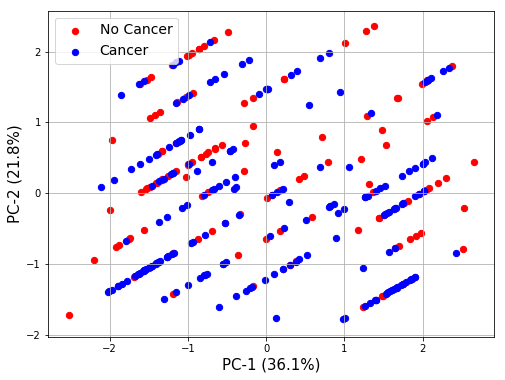

In [91]:
fig = plt.figure(figsize = (8,6))


ax = fig.add_subplot(1,1,1) 
ax.set_xlabel("PC-1 ({:.1f}%)".format(100*v1), fontsize = 15)
ax.set_ylabel("PC-2 ({:.1f}%)".format(100*v2), fontsize = 15)

colors = ['r', 'b']
targets = [0, 1]

for target, color in zip(targets,colors):
    idx = pca_df['cancer'] == target
    ax.scatter(pca_df.loc[idx, 'pc1'], pca_df.loc[idx, 'pc2'], c = color, s = 40)
ax.legend(["No Cancer", "Cancer"])
ax.grid()

## Model Testing

### Weighted Voting

In [640]:
wv_clinical = WeightedVotingClassifier(class_score = t_score)
wv_clinical.fit(X_train_clinical, y_train)

In [641]:
scores = cross_val_score(wv_clinical, X_train_clinical, y_train, cv = 10, scoring = "recall")
accuracy = np.mean(scores)

print("Mean CV Recall = {}".format(accuracy))

Mean CV Accuracy = 0.5676470588235294


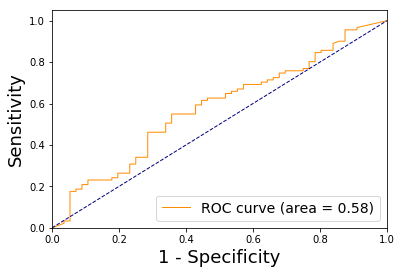

In [642]:
fpr, tpr, roc_auc = calc_roc_auc(wv_clinical, X_test_clinical, y_test)

plot_roc_curve(fpr, tpr, roc_auc)

### Logistic Regression 

In [276]:
lr_clinical = LogisticRegression(solver = "newton-cg")
lr_clinical.fit(X_train_clinical, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='newton-cg',
          tol=0.0001, verbose=0, warm_start=False)

In [279]:
scores = cross_val_score(lr_clinical, X_train_clinical, y_train, cv = 10, scoring = "recall")
accuracy = np.mean(scores)

print("Mean CV Recall = {}".format(accuracy))

Mean CV Accuracy = 0.64349376114082


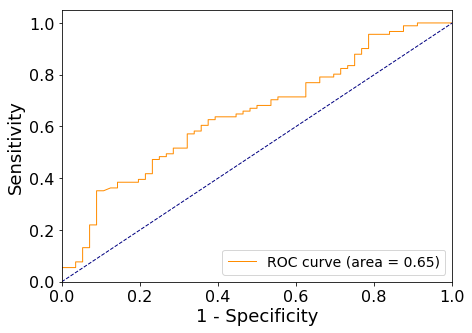

In [292]:
fpr, tpr, roc_auc = calc_roc_auc(lr_clinical, X_test_clinical, y_test)

plot_roc_curve(fpr, tpr, roc_auc)

### SVM

In [283]:
svr_clinical = svm.SVC(C = 2.5, gamma = "auto", kernel = "rbf")
svr_clinical.fit(X_train_clinical, y_train)

SVC(C=2.5, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [284]:
scores = cross_val_score(svr_clinical, X_train_clinical, y_train, cv = 10, scoring = "recall")
accuracy = np.mean(scores)

print("Mean CV Recall = {}".format(accuracy))

Mean CV Accuracy = 0.7117850776674306


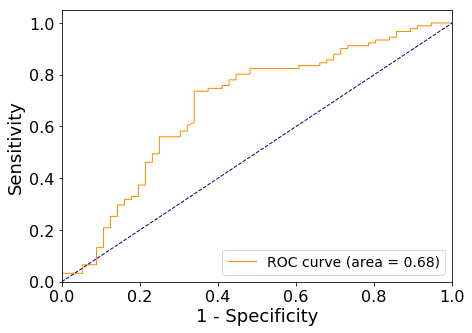

In [293]:
fpr, tpr, roc_auc = calc_roc_auc(svr_clinical, X_test_clinical, y_test)

plot_roc_curve(fpr, tpr, roc_auc)

### Random Forest

In [140]:
rfc_clinical = RandomForestClassifier(random_state = 12345)


parameters = {
    'n_estimators': [50, 100, 500, 1000], 
    'max_depth': [1, 2, 5, 10, None],
    'criterion': ['gini', 'entropy']
}

clf = GridSearchCV(rfc_clinical, parameters, cv = 10, n_jobs = -1)
clf.fit(X_train_clinical, y_train)

clf.best_params_

/Users/sfriedowitz/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'criterion': 'gini', 'max_depth': 5, 'n_estimators': 1000}

In [144]:
rfc_clinical = RandomForestClassifier(n_estimators = 1000,
                             max_depth = 5, 
                             criterion="gini",
                             random_state = 12345)

rfc_clinical.fit(X_train_clinical, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=5, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=None,
            oob_score=False, random_state=12345, verbose=0,
            warm_start=False)

In [145]:
scores = cross_val_score(rfc_clinical, X_train_clinical, y_train, cv = 10, scoring = "recall")
accuracy = np.mean(scores)

print("Mean CV Recall = {}".format(accuracy))

Mean CV Recall = 0.8219047619047618


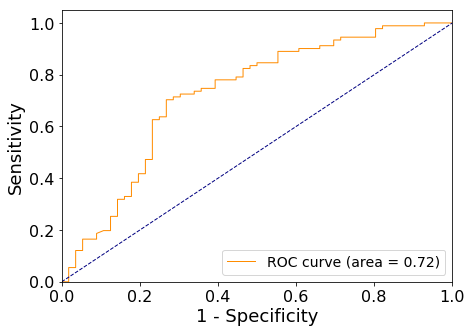

In [146]:
fpr, tpr, roc_auc = calc_roc_auc(rfc_clinical, X_test_clinical, y_test)

plot_roc_curve(fpr, tpr, roc_auc)

# Feature and Model Selection

In [657]:
# Pull Data
X_train = train_df.iloc[:,1:].values
y_train = train_df.iloc[:,0].values
X_test = test_df.iloc[:,1:].values
y_test = test_df.iloc[:,0].values

X_train = StandardScaler().fit_transform(X_train)
X_test = StandardScaler().fit_transform(X_test)

In [658]:
X_train_clinical = X_train[:,0:5]
X_test_clinical = X_test[:,0:5]

X_train_rna = X_train[:,5:]
X_test_rna = X_test[:,5:]

## Logistic Regression

### T-Score

In [757]:
max_nf = 100
max_cv = 0
max_k = 0

k_vals = np.arange(5, max_nf + 1, 1)

cv_score = np.zeros(k_vals.shape[0])
cv_std = np.zeros(k_vals.shape[0])
roc_auc = np.zeros(k_vals.shape[0])

for i, k in enumerate(k_vals):
    
    selector = SelectKBest(t_score, k = k)
    selector.fit(X_train, y_train)
    
    X_train_sel = selector.transform(X_train)
    X_test_sel = selector.transform(X_test)
      
    lr = LogisticRegression(solver = "newton-cg")
    lr.fit(X_train_sel, y_train)
    scores = cross_val_score(lr, X_train_sel, y_train, cv = 10, scoring = "recall")
    cv = np.mean(scores)
    cvs = np.std(scores)
    
    if cv > max_cv:
        max_cv = cv
        max_k = k
        print("k = {}, Mean CV Score = {}".format(max_k, max_cv))
        
    cv_score[i] = cv
    cv_std[i] = cvs
    
    _, _, area = calc_roc_auc(lr, X_test_sel, y_test)
    roc_auc[i] = area

k = 5, Mean CV Score = 0.8254761904761905


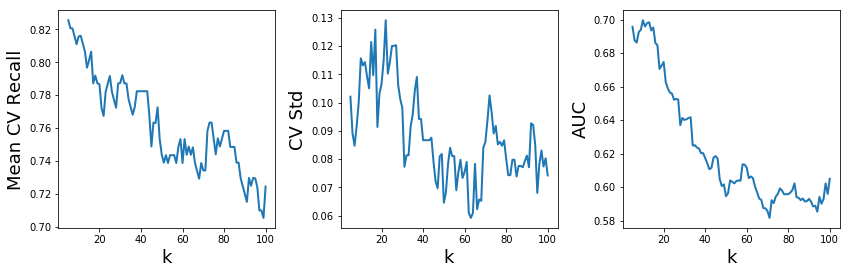

In [758]:
fig, ax = plt.subplots(1, 3, figsize=(14,4)) 
plt.subplots_adjust(wspace = 0.3)

ax1, ax2, ax3 = ax

ax1.plot(k_vals, cv_score)
ax1.set_xlabel("k")
ax1.set_ylabel("Mean CV Recall")

ax2.plot(k_vals, cv_std)
ax2.set_xlabel("k")
ax2.set_ylabel("CV Std")

ax3.plot(k_vals, roc_auc)
ax3.set_xlabel("k")
ax3.set_ylabel("AUC")

plt.show()

### F-Value

In [759]:
max_nf = 100
max_cv = 0
max_k = 0

k_vals = np.arange(5, max_nf + 1, 1)

cv_score = np.zeros(k_vals.shape[0])
cv_std = np.zeros(k_vals.shape[0])
roc_auc = np.zeros(k_vals.shape[0])

for i, k in enumerate(k_vals):
    
    selector = SelectKBest(t_score, k = k)
    selector.fit(X_train, y_train)
    
    X_train_sel = selector.transform(X_train)
    X_test_sel = selector.transform(X_test)
      
    lr = LogisticRegression(solver = "newton-cg")
    lr.fit(X_train_sel, y_train)
    scores = cross_val_score(lr, X_train_sel, y_train, cv = 10, scoring = "recall")
    cv = np.mean(scores)
    cvs = np.std(scores)
    
    if cv > max_cv:
        max_cv = cv
        max_k = k
        print("k = {}, Mean CV Score = {}".format(max_k, max_cv))
        
    cv_score[i] = cv
    cv_std[i] = cvs
    
    _, _, area = calc_roc_auc(lr, X_test_sel, y_test)
    roc_auc[i] = area

k = 5, Mean CV Score = 0.8254761904761905


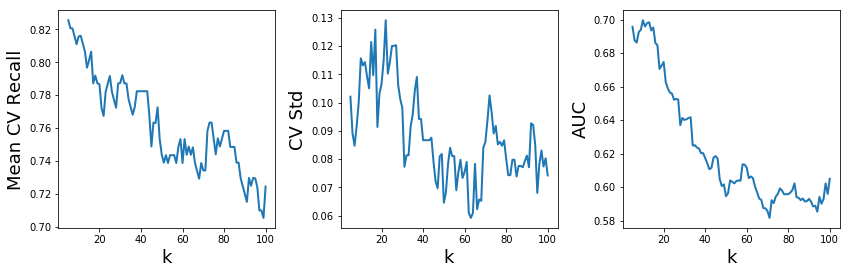

In [760]:
fig, ax = plt.subplots(1, 3, figsize=(14,4)) 
plt.subplots_adjust(wspace = 0.3)

ax1, ax2, ax3 = ax

ax1.plot(k_vals, cv_score)
ax1.set_xlabel("k")
ax1.set_ylabel("Mean CV Recall")

ax2.plot(k_vals, cv_std)
ax2.set_xlabel("k")
ax2.set_ylabel("CV Std")

ax3.plot(k_vals, roc_auc)
ax3.set_xlabel("k")
ax3.set_ylabel("AUC")

plt.show()

### Tree-Based

In [767]:
max_nf = 100
max_cv = 0
max_k = 0

k_vals = np.arange(5, max_nf + 1, 1)

cv_score = np.zeros(k_vals.shape[0])
cv_std = np.zeros(k_vals.shape[0])
roc_auc = np.zeros(k_vals.shape[0])

model = ExtraTreesClassifier(n_estimators = 100, random_state = 12345)
model.fit(X_train_rna, y_train)

for i, k in enumerate(k_vals):
    
    selector = SelectFromModel(model, prefit = True, max_features = k)

    X_train_sel = selector.transform(X_train_rna)
    X_test_sel = selector.transform(X_test_rna)

    lr = LogisticRegression(solver = "newton-cg")
    lr.fit(X_train_sel, y_train)
    scores = cross_val_score(lr, X_train_sel, y_train, cv = 10, scoring = "recall")
    cv = np.mean(scores)
    cvs = np.std(scores)
    
    if cv > max_cv:
        max_cv = cv
        max_k = k
        print("k = {}, Mean CV Score = {}".format(max_k, max_cv))
        
    cv_score[i] = cv
    cv_std[i] = cvs
    
    _, _, area = calc_roc_auc(lr, X_test_sel, y_test)
    roc_auc[i] = area

k = 5, Mean CV Score = 0.8402380952380952
k = 6, Mean CV Score = 0.8442857142857143
k = 8, Mean CV Score = 0.8492857142857142
k = 9, Mean CV Score = 0.8595238095238095


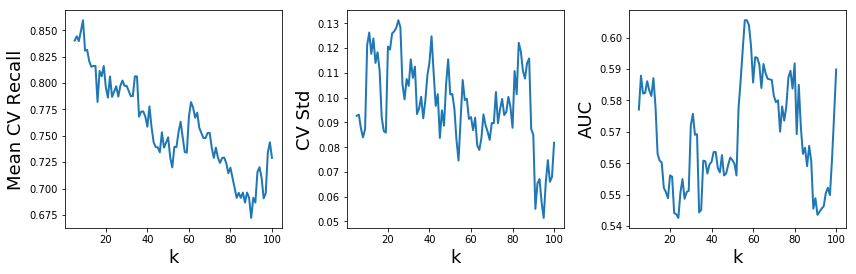

In [763]:
fig, ax = plt.subplots(1, 3, figsize=(14,4)) 
plt.subplots_adjust(wspace = 0.3)

ax1, ax2, ax3 = ax

ax1.plot(k_vals, cv_score)
ax1.set_xlabel("k")
ax1.set_ylabel("Mean CV Recall")

ax2.plot(k_vals, cv_std)
ax2.set_xlabel("k")
ax2.set_ylabel("CV Std")

ax3.plot(k_vals, roc_auc)
ax3.set_xlabel("k")
ax3.set_ylabel("AUC")

plt.show()

## SVM

### T-Score

In [752]:
max_nf = 100
max_cv = 0
max_k = 0

k_vals = np.arange(5, max_nf + 1, 1)

cv_score = np.zeros(k_vals.shape[0])
cv_std = np.zeros(k_vals.shape[0])
roc_auc = np.zeros(k_vals.shape[0])

for i, k in enumerate(k_vals):
    
    selector = SelectKBest(t_score, k = k)
    selector.fit(X_train, y_train)
    
    X_train_sel = selector.transform(X_train)
    X_test_sel = selector.transform(X_test)
      
    svr = svm.SVC(C = 3, gamma = "auto", kernel = "rbf")
    svr.fit(X_train_sel, y_train)
    scores = cross_val_score(svr, X_train_sel, y_train, cv = 10, scoring = "recall")
    cv = np.mean(scores)
    cvs = np.std(scores)
    
    if cv > max_cv:
        max_cv = cv
        max_k = k
        print("k = {}, Mean CV Score = {}".format(max_k, max_cv))
        
    cv_score[i] = cv
    cv_std[i] = cvs
    
    _, _, area = calc_roc_auc(svr, X_test_sel, y_test)
    roc_auc[i] = area

k = 5, Mean CV Score = 0.8600000000000001
k = 9, Mean CV Score = 0.8645238095238096


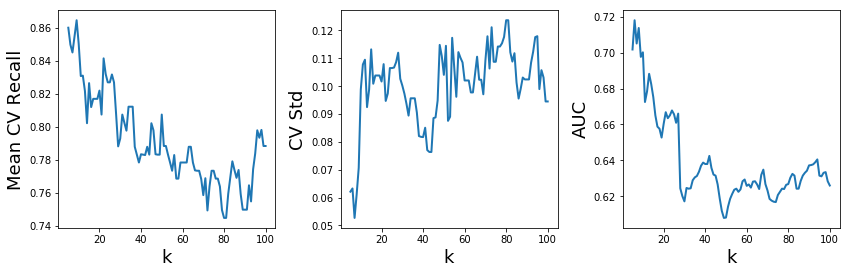

In [756]:
fig, ax = plt.subplots(1, 3, figsize=(14,4)) 
plt.subplots_adjust(wspace = 0.3)

ax1, ax2, ax3 = ax

ax1.plot(k_vals, cv_score)
ax1.set_xlabel("k")
ax1.set_ylabel("Mean CV Recall")

ax2.plot(k_vals, cv_std)
ax2.set_xlabel("k")
ax2.set_ylabel("CV Std")

ax3.plot(k_vals, roc_auc)
ax3.set_xlabel("k")
ax3.set_ylabel("AUC")

plt.show()

### F-Value

In [750]:
max_nf = 100
max_cv = 0
max_k = 0

k_vals = np.arange(5, max_nf + 1, 1)

cv_score = np.zeros(k_vals.shape[0])
cv_std = np.zeros(k_vals.shape[0])
roc_auc = np.zeros(k_vals.shape[0])

for i, k in enumerate(k_vals):
    
    selector = SelectKBest(f_classif, k = k)
    selector.fit(X_train, y_train)
    
    X_train_sel = selector.transform(X_train)
    X_test_sel = selector.transform(X_test)
      
    svr = svm.SVC(C = 3, gamma = "auto", kernel = "rbf")
    svr.fit(X_train_sel, y_train)
    scores = cross_val_score(svr, X_train_sel, y_train, cv = 10, scoring = "recall")
    cv = np.mean(scores)
    cvs = np.std(scores)
    
    if cv > max_cv:
        max_cv = cv
        max_k = k
        print("k = {}, Mean CV Score = {}".format(max_k, max_cv))
        
    cv_score[i] = cv
    cv_std[i] = cvs
    
    _, _, area = calc_roc_auc(svr, X_test_sel, y_test)
    roc_auc[i] = area

k = 5, Mean CV Score = 0.8549999999999999


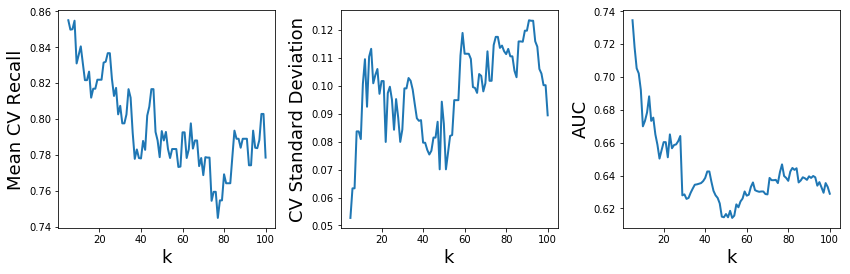

In [751]:
fig, ax = plt.subplots(1, 3, figsize=(14,4)) 
plt.subplots_adjust(wspace = 0.3)

ax1, ax2, ax3 = ax

ax1.plot(k_vals, cv_score)
ax1.set_xlabel("k")
ax1.set_ylabel("Mean CV Recall")

ax2.plot(k_vals, cv_std)
ax2.set_xlabel("k")
ax2.set_ylabel("CV Std")

ax3.plot(k_vals, roc_auc)
ax3.set_xlabel("k")
ax3.set_ylabel("AUC")

plt.show()

### Tree Based

In [765]:
max_nf = 100
max_cv = 0
max_k = 0

k_vals = np.arange(5, max_nf + 1, 1)

cv_score = np.zeros(k_vals.shape[0])
cv_std = np.zeros(k_vals.shape[0])
roc_auc = np.zeros(k_vals.shape[0])

model = ExtraTreesClassifier(n_estimators = 100, random_state = 12345)
model.fit(X_train, y_train)

for i, k in enumerate(k_vals):
    
    selector = SelectFromModel(model, prefit = True, max_features = k)

    X_train_sel = selector.transform(X_train)
    X_test_sel = selector.transform(X_test)

    svr = svm.SVC(C = 3, gamma = "auto", kernel = "rbf")
    svr.fit(X_train_sel, y_train)
    scores = cross_val_score(svr, X_train_sel, y_train, cv = 10, scoring = "recall")
    cv = np.mean(scores)
    cvs = np.std(scores)
    
    if cv > max_cv:
        max_cv = cv
        max_k = k
        print("k = {}, Mean CV Score = {}".format(max_k, max_cv))
        
    cv_score[i] = cv
    cv_std[i] = cvs
    
    _, _, area = calc_roc_auc(svr, X_test_sel, y_test)
    roc_auc[i] = area

k = 5, Mean CV Score = 0.8202380952380952
k = 78, Mean CV Score = 0.8221428571428572


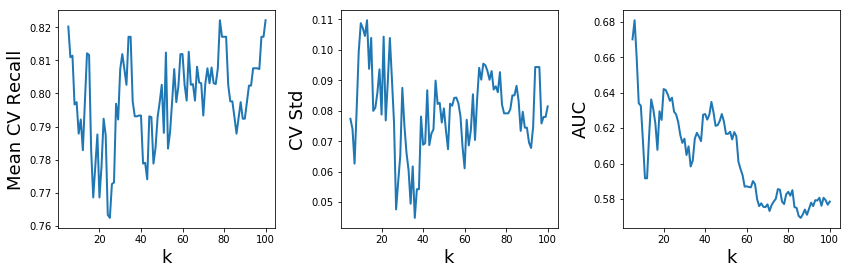

In [766]:
fig, ax = plt.subplots(1, 3, figsize=(14,4)) 
plt.subplots_adjust(wspace = 0.3)

ax1, ax2, ax3 = ax

ax1.plot(k_vals, cv_score)
ax1.set_xlabel("k")
ax1.set_ylabel("Mean CV Recall")

ax2.plot(k_vals, cv_std)
ax2.set_xlabel("k")
ax2.set_ylabel("CV Std")

ax3.plot(k_vals, roc_auc)
ax3.set_xlabel("k")
ax3.set_ylabel("AUC")

plt.show()

## Random Forest

### T-Score

In [769]:
max_nf = 100
max_cv = 0
max_k = 0

k_vals = np.arange(5, max_nf + 1, 1)

cv_score = np.zeros(k_vals.shape[0])
cv_std = np.zeros(k_vals.shape[0])
roc_auc = np.zeros(k_vals.shape[0])

for i, k in enumerate(k_vals):
    
    selector = SelectKBest(t_score, k = k)
    selector.fit(X_train, y_train)
    
    X_train_sel = selector.transform(X_train)
    X_test_sel = selector.transform(X_test)
      
    rfc = RandomForestClassifier(n_estimators = 100, random_state = 12345)
    rfc.fit(X_train_sel, y_train)
    scores = cross_val_score(rfc, X_train_sel, y_train, cv = 10, scoring = "recall")
    cv = np.mean(scores)
    cvs = np.std(scores)
    
    if cv > max_cv:
        max_cv = cv
        max_k = k
        print("k = {}, Mean CV Score = {}".format(max_k, max_cv))
        
    cv_score[i] = cv
    cv_std[i] = cvs
    
    _, _, area = calc_roc_auc(rfc, X_test_sel, y_test)
    roc_auc[i] = area

k = 5, Mean CV Score = 0.8116666666666668
k = 6, Mean CV Score = 0.8209523809523811
k = 7, Mean CV Score = 0.8352380952380953
k = 68, Mean CV Score = 0.8507142857142856


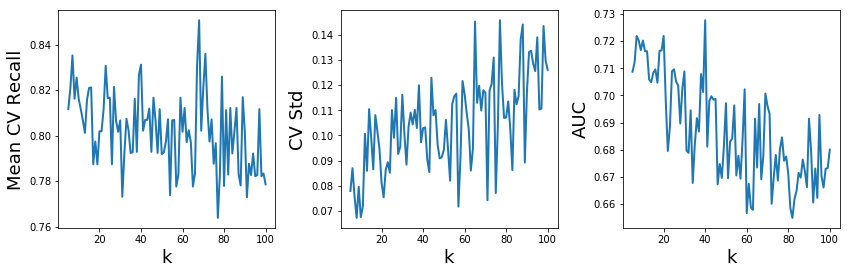

In [771]:
fig, ax = plt.subplots(1, 3, figsize=(14,4)) 
plt.subplots_adjust(wspace = 0.3)

ax1, ax2, ax3 = ax

ax1.plot(k_vals, cv_score)
ax1.set_xlabel("k")
ax1.set_ylabel("Mean CV Recall")

ax2.plot(k_vals, cv_std)
ax2.set_xlabel("k")
ax2.set_ylabel("CV Std")

ax3.plot(k_vals, roc_auc)
ax3.set_xlabel("k")
ax3.set_ylabel("AUC")

plt.show()

### F-Value

In [772]:
max_nf = 100
max_cv = 0
max_k = 0

k_vals = np.arange(5, max_nf + 1, 1)

cv_score = np.zeros(k_vals.shape[0])
cv_std = np.zeros(k_vals.shape[0])
roc_auc = np.zeros(k_vals.shape[0])

for i, k in enumerate(k_vals):
    
    selector = SelectKBest(f_classif, k = k)
    selector.fit(X_train, y_train)
    
    X_train_sel = selector.transform(X_train)
    X_test_sel = selector.transform(X_test)
      
    rfc = RandomForestClassifier(n_estimators = 100, random_state = 12345)
    rfc.fit(X_train_sel, y_train)
    scores = cross_val_score(rfc, X_train_sel, y_train, cv = 10, scoring = "recall")
    cv = np.mean(scores)
    cvs = np.std(scores)
    
    if cv > max_cv:
        max_cv = cv
        max_k = k
        print("k = {}, Mean CV Score = {}".format(max_k, max_cv))
        
    cv_score[i] = cv
    cv_std[i] = cvs
    
    _, _, area = calc_roc_auc(rfc, X_test_sel, y_test)
    roc_auc[i] = area

k = 5, Mean CV Score = 0.7969047619047619
k = 6, Mean CV Score = 0.8209523809523811
k = 8, Mean CV Score = 0.830952380952381
k = 52, Mean CV Score = 0.8314285714285713


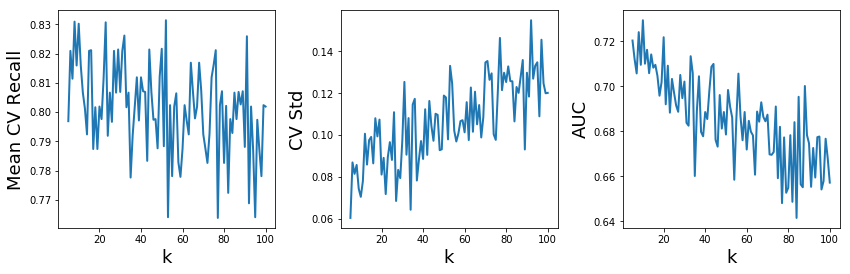

In [773]:
fig, ax = plt.subplots(1, 3, figsize=(14,4)) 
plt.subplots_adjust(wspace = 0.3)

ax1, ax2, ax3 = ax

ax1.plot(k_vals, cv_score)
ax1.set_xlabel("k")
ax1.set_ylabel("Mean CV Recall")

ax2.plot(k_vals, cv_std)
ax2.set_xlabel("k")
ax2.set_ylabel("CV Std")

ax3.plot(k_vals, roc_auc)
ax3.set_xlabel("k")
ax3.set_ylabel("AUC")

plt.show()

### Tree Based

In [38]:
max_nf = 100
max_cv = 0
max_k = 0

k_vals = np.arange(5, max_nf + 1, 1)

cv_score = np.zeros(k_vals.shape[0])
cv_std = np.zeros(k_vals.shape[0])
roc_auc = np.zeros(k_vals.shape[0])


model = ExtraTreesClassifier(n_estimators = 100, random_state = 12345)
model.fit(X_train, y_train)

for i, k in enumerate(k_vals):
    
    selector = SelectFromModel(model, prefit = True, max_features = k)

    X_train_sel = selector.transform(X_train)
    X_test_sel = selector.transform(X_test)

    rfc = RandomForestClassifier(n_estimators = 100, random_state = 12345)
    rfc.fit(X_train_sel, y_train)
    scores = cross_val_score(rfc, X_train_sel, y_train, cv = 10, scoring = "recall")
    cv = np.mean(scores)
    cvs = np.std(scores)
    
    if cv > max_cv:
        max_cv = cv
        max_k = k
        print("k = {}, Mean CV Score = {}".format(max_k, max_cv))
        
    cv_score[i] = cv
    cv_std[i] = cvs
    
    _, _, area = calc_roc_auc(rfc, X_test_sel, y_test)
    roc_auc[i] = area

k = 5, Mean CV Score = 0.7824675324675324
k = 6, Mean CV Score = 0.7826839826839825
k = 8, Mean CV Score = 0.8012987012987013
k = 11, Mean CV Score = 0.8348484848484847


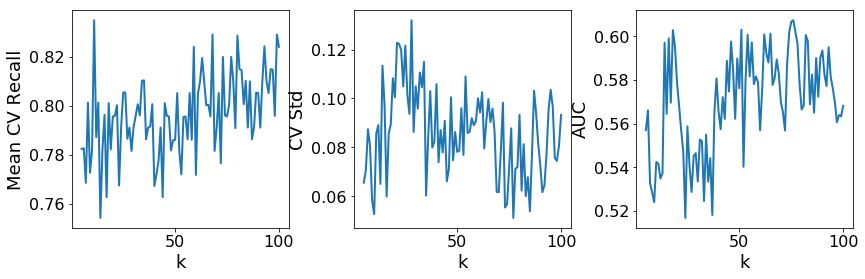

In [39]:
fig, ax = plt.subplots(1, 3, figsize=(14,4)) 
plt.subplots_adjust(wspace = 0.3)

ax1, ax2, ax3 = ax

ax1.plot(k_vals, cv_score)
ax1.set_xlabel("k")
ax1.set_ylabel("Mean CV Recall")

ax2.plot(k_vals, cv_std)
ax2.set_xlabel("k")
ax2.set_ylabel("CV Std")

ax3.plot(k_vals, roc_auc)
ax3.set_xlabel("k")
ax3.set_ylabel("AUC")

plt.show()

# Model Tuning

In this section, we optimize hyperparameters for both an SVM and RF classifier, using the optimal feature subset determined from the above analysis.

In [40]:
# Pull Data
X_train = train_df.iloc[:,1:].values
y_train = train_df.iloc[:,0].values
X_test = test_df.iloc[:,1:].values
y_test = test_df.iloc[:,0].values

X_train = StandardScaler().fit_transform(X_train)
X_test = StandardScaler().fit_transform(X_test)

In [41]:
X_train_clinical = X_train[:,0:5]
X_test_clinical = X_test[:,0:5]

X_train_rna = X_train[:,5:]
X_test_rna = X_test[:,5:]

Choose 53 best features from a tree-based classifier to use in the model.

In [42]:
model = ExtraTreesClassifier(n_estimators = 100, random_state = 12345)
model.fit(X_train, y_train)

np.argsort(-model.feature_importances_)[:53]

array([    4,  7447,  6477, 25762, 18629,  1289,  2359, 32111,  5276,
       18581, 25294, 21997, 18746,  6339,  8456,  3207, 30676, 28444,
       32005, 17861, 25085, 15338,  3669,  3208, 30336, 19869,  7890,
       20810,  8487, 23322, 29401, 25641, 15667,  5887, 24949, 31269,
       17413, 15548, 22430, 15606, 26469, 16111, 18728, 30298,  7017,
       20278,  9972, 27776, 15941, 30571, 22419, 20385, 24668])

In [22]:
selector = SelectFromModel(model, prefit = True, max_features = 53)

X_train_sel = selector.transform(X_train)
X_test_sel = selector.transform(X_test)

## SVM

In [875]:
svr = svm.SVC()

parameters = {
    'kernel': ['rbf'], 
    'C': [1, 1.25, 1.3, 1.35], 
    'gamma': ['auto', 'scale']
}

clf = GridSearchCV(svr, parameters, cv = 10)
clf.fit(X_train_sel, y_train)

clf.best_params_

/Users/sfriedowitz/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'C': 1.25, 'gamma': 'auto', 'kernel': 'rbf'}

In [876]:
svr = svm.SVC(C = 1.25, kernel = 'rbf', gamma = 'auto')
svr.fit(X_train_sel, y_train)

SVC(C=1.25, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [877]:
scores = cross_val_score(svr, X_train_sel, y_train, cv = 10, scoring = "recall")
np.mean(scores)

0.8511904761904763

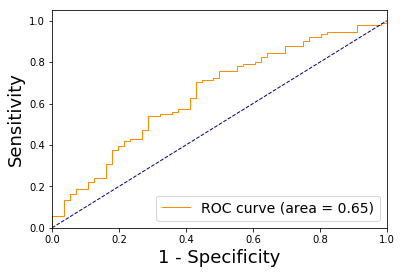

In [878]:
fpr, tpr, roc_auc = calc_roc_auc(svr, X_test_sel, y_test)

plot_roc_curve(fpr, tpr, roc_auc)

## Random Forest

### Parameter Tuning

This takes a very long time to run since of the high dimensional parameter space.

In [21]:
rfc = RandomForestClassifier(random_state = 12345)


parameters = {
    'n_estimators': [50, 100, 500, 1000], 
    'max_depth': [1, 2, 5, 10, None], 
    'max_features': [0.1, 0.2, 0.5, 0.75],
    'criterion': ['gini', 'entropy']
}

clf = GridSearchCV(rfc, parameters, cv = 10, n_jobs = -1)
clf.fit(X_train_sel, y_train)

clf.best_params_

/Users/sfriedowitz/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'criterion': 'gini',
 'max_depth': None,
 'max_features': 0.2,
 'n_estimators': 500}

In [35]:
rfc = RandomForestClassifier(n_estimators = 500,
                             max_depth = None, 
                             max_features = 0.2,
                             criterion="gini",
                             random_state = 12345)

rfc.fit(X_train_sel, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features=0.2, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=None,
            oob_score=False, random_state=12345, verbose=0,
            warm_start=False)

In [36]:
scores = cross_val_score(rfc, X_train_sel, y_train, cv = 10, scoring = "recall")
np.mean(scores)

0.8795238095238096

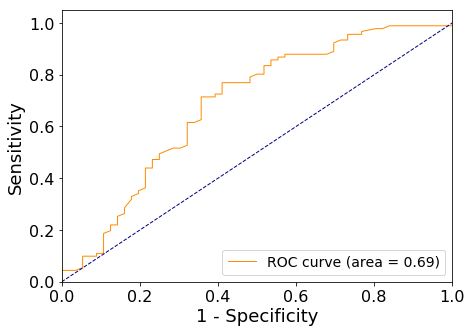

In [37]:
fpr, tpr, roc_auc = calc_roc_auc(rfc, X_test_sel, y_test)

plot_roc_curve(fpr, tpr, roc_auc)

In [38]:
y_test_pred = rfc.predict(X_test_sel)

sklearn.metrics.confusion_matrix(y_test, y_test_pred)

array([[26, 30],
       [15, 76]])

In [39]:
sklearn.metrics.recall_score(y_test, y_test_pred)

0.8351648351648352

### PCA Reduction

In [106]:
var = 0
k = 1

while var < 0.9:
    
    pca = PCA(n_components = k)
    pca.fit(X_train_sel)
    
    var = np.sum(pca.explained_variance_ratio_)
    
    print("k = {}, Explained variance = {}".format(k, var))
    
    k += 1
    

k = 1, Explained variance = 0.18721790775102815
k = 2, Explained variance = 0.32424274421528554
k = 3, Explained variance = 0.39917973083682495
k = 4, Explained variance = 0.4399825022419377
k = 5, Explained variance = 0.47751569161967605
k = 6, Explained variance = 0.5075341805256888
k = 7, Explained variance = 0.5343054003830732
k = 8, Explained variance = 0.5588926099045778
k = 9, Explained variance = 0.5824184969175499
k = 10, Explained variance = 0.6036825292446566
k = 11, Explained variance = 0.6245694323892138
k = 12, Explained variance = 0.6447884447837592
k = 13, Explained variance = 0.663105686028306
k = 14, Explained variance = 0.6808274553845183
k = 15, Explained variance = 0.6976651466677628
k = 16, Explained variance = 0.7139774356471617
k = 17, Explained variance = 0.729700418976673
k = 18, Explained variance = 0.7451037753629155
k = 19, Explained variance = 0.7593059763514338
k = 20, Explained variance = 0.7731709656150846
k = 21, Explained variance = 0.7861051620384271

In [117]:
k = 33

pca = PCA(n_components = k)
X_train_pca = pca.fit_transform(X_train_sel)
X_test_pca = pca.transform(X_test_sel)

X0_pca = X_train_pca[y_train == 0]
X1_pca = X_train_pca[y_train == 1]

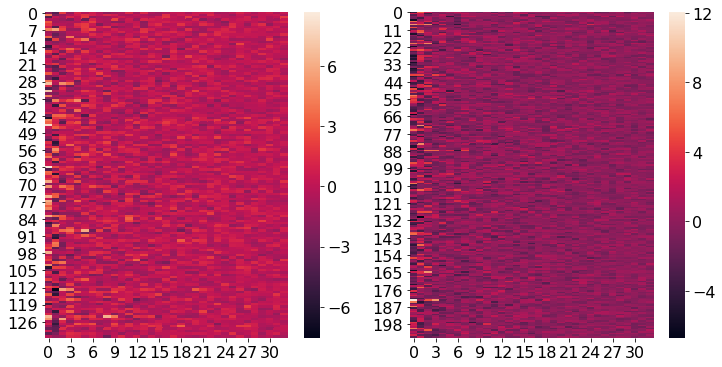

In [118]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,6), sharey = True)
sns.heatmap(X0_pca, ax = ax1)
sns.heatmap(X1_pca, ax = ax2)
plt.show()

In [119]:
rfc = RandomForestClassifier(n_estimators = 500,
                             max_depth = None, 
                             max_features = 0.2,
                             criterion="gini",
                             random_state = 12345)

rfc.fit(X_train_pca, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features=0.2, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=None,
            oob_score=False, random_state=12345, verbose=0,
            warm_start=False)

In [120]:
scores = cross_val_score(rfc, X_train_pca, y_train, cv = 10, scoring = "recall")
np.mean(scores)

0.8604761904761904

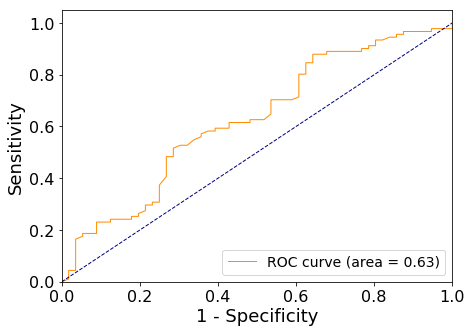

In [121]:
fpr, tpr, roc_auc = calc_roc_auc(rfc, X_test_pca, y_test)

plot_roc_curve(fpr, tpr, roc_auc)

In [122]:
y_test_pred = rfc.predict(X_test_pca)

sklearn.metrics.confusion_matrix(y_test, y_test_pred)

array([[17, 39],
       [10, 81]])

In [123]:
sklearn.metrics.recall_score(y_test, y_test_pred)

0.8901098901098901

# Model Testing

In [43]:
# Pull Data
X_train = train_df.iloc[:,1:].values
y_train = train_df.iloc[:,0].values
X_test = test_df.iloc[:,1:].values
y_test = test_df.iloc[:,0].values

X_train = StandardScaler().fit_transform(X_train)
X_test = StandardScaler().fit_transform(X_test)

In [44]:
X_train_clinical = X_train[:,0:5]
X_test_clinical = X_test[:,0:5]

X_train_rna = X_train[:,5:]
X_test_rna = X_test[:,5:]

In [45]:
top_features = np.array([
    4, 7447,  6477, 25762, 18629,  1289,  2359, 32111,  5276,
    18581, 25294, 21997, 18746,  6339,  8456,  3207, 30676, 28444,
    32005, 17861, 25085, 15338,  3669,  3208, 30336, 19869,  7890,
    20810,  8487, 23322, 29401, 25641, 15667,  5887, 24949, 31269,
    17413, 15548, 22430, 15606, 26469, 16111, 18728, 30298,  7017,
    20278,  9972, 27776, 15941, 30571, 22419, 20385, 24668
])

In [46]:
X_train_sel = X_train[:, top_features]
X_test_sel = X_test[:, top_features]

In [47]:
pca = PCA(n_components = 33)
X_train_pca = pca.fit_transform(X_train_sel)
X_test_pca = pca.transform(X_test_sel)

Clinical Model:

In [48]:
rfc_clinical = RandomForestClassifier(n_estimators = 1000,
                             max_depth = 5, 
                             criterion="gini",
                             random_state = 12345)

rfc_clinical.fit(X_train_clinical, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=5, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=None,
            oob_score=False, random_state=12345, verbose=0,
            warm_start=False)

Full Model:

In [49]:
rfc_full = RandomForestClassifier(n_estimators = 500,
                             max_depth = None, 
                             max_features = 0.2,
                             criterion="gini",
                             random_state = 12345)

rfc_full.fit(X_train_pca, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features=0.2, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=None,
            oob_score=False, random_state=12345, verbose=0,
            warm_start=False)

## Testing

In [170]:
y_clinical_pred = rfc_clinical.predict(X_test_clinical)
y_full_pred = rfc_full.predict(X_test_pca)

In [161]:
recall_c = cross_val_score(rfc_clinical, X_train_clinical, y_train, cv = 10, scoring = "recall")
recall_f = cross_val_score(rfc_full, X_train_pca, y_train, cv = 10, scoring = "recall")

recall_c = np.mean(recall_c)
recall_f = np.mean(recall_f)

print("Mean Clincal Recall = {}\nMean Full Recall = {}".format(recall_c, recall_f))

Mean Clincal Recall = 0.8219047619047618
Mean Full Recall = 0.8604761904761904


In [178]:
accuracy_c = sklearn.metrics.accuracy_score(y_test, y_clinical_pred)
accuracy_f = sklearn.metrics.accuracy_score(y_test, y_full_pred)

print("Clinical Accuracy = {}\nFull Accuracy = {}".format(accuracy_c, accuracy_f))

Clinical Accuracy = 0.7006802721088435
Full Accuracy = 0.6666666666666666


In [177]:
recall_c = sklearn.metrics.recall_score(y_test, y_clinical_pred)
recall_f = sklearn.metrics.recall_score(y_test, y_full_pred)

print("Clinical Recall = {}\nFull Recall = {}".format(recall_c, recall_f))

Clinical Recall = 0.7912087912087912
Full Recall = 0.8901098901098901


In [176]:
precision_c = sklearn.metrics.precision_score(y_test, y_clinical_pred)
precision_f = sklearn.metrics.precision_score(y_test, y_full_pred)

print("Clinical Precision = {}\nFull Precision = {}".format(precision_c, precision_f))

Clinical Precision = 0.7422680412371134
Full Precision = 0.675


In [182]:
fpr_c, tpr_c, roc_auc_c = calc_roc_auc(rfc_clinical, X_test_clinical, y_test)
fpr_f, tpr_f, roc_auc_f = calc_roc_auc(rfc_full, X_test_pca, y_test)

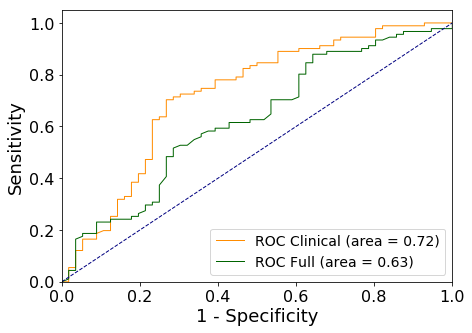

In [187]:
plt.figure()
plt.plot(fpr_c, tpr_c, color='darkorange', lw=1, label='ROC Clinical (area = %0.2f)' % roc_auc_c)
plt.plot(fpr_f, tpr_f, color='darkgreen', lw=1, label='ROC Full (area = %0.2f)' % roc_auc_f)
plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])


plt.xlabel('1 - Specificity')
plt.ylabel('Sensitivity')
plt.legend(loc="lower right")

plt.show()

# Gene Names for Top Genes

In [53]:
top_features = np.array([
    4, 7447,  6477, 25762, 18629,  1289,  2359, 32111,  5276,
    18581, 25294, 21997, 18746,  6339,  8456,  3207, 30676, 28444,
    32005, 17861, 25085, 15338,  3669,  3208, 30336, 19869,  7890,
    20810,  8487, 23322, 29401, 25641, 15667,  5887, 24949, 31269,
    17413, 15548, 22430, 15606, 26469, 16111, 18728, 30298,  7017,
    20278,  9972, 27776, 15941, 30571, 22419, 20385, 24668
]) 

tf1 = top_features + 1

Load lookup dictionary (created in parse_data)

In [51]:
f = open('data/gene_dict.pkl','rb')
gene_dict = pickle.load(f)
f.close()

Get the top gene IDs

In [54]:
top_gene_IDs = train_df.iloc[0:1,tf1].columns
top_gene_IDs

Index(['mass_size', '7931899', '7921738', '8117301', '8045343', '7893812',
       '7894907', '8180078', '7909188', '8045028', '8112998', '8080144',
       '8046527', '7920205', '7941749', '7895770', '8166059', '8144226',
       '8179019', '8038292', '8110932', '8012856', '7896248', '7895771',
       '8162514', '8058591', '7936673', '8068057', '7942204', '8094028',
       '8153021', '8116316', '8016257', '7915657', '8109618', '8171449',
       '8033912', '8014974', '8084627', '8015607', '8124413', '8020827',
       '8046340', '8162177', '7927120', '8063000', '7956044', '8137979',
       '8019308', '8165046', '8084397', '8064042', '8106771'],
      dtype='object')

The first feature is clinical data. In the below, missing entries have not been identified as genes for a particular mRNA (i.e. if a gene ID is missing we don't know exactly what it is. Affimetrix updates their database twice a year).

In [55]:
best_feats = [['mass_size', ('N/A')]]
best_feats.append( [[i,gene_dict[i]] for i in top_gene_IDs[1:] if (i in gene_dict)] )
best_feats

[['mass_size', 'N/A'],
 [['7931899', ('IL15RA',)],
  ['7921738', ('USF1',)],
  ['8117301', ('HIST1H2BA',)],
  ['8180078', ('HLA-DMB',)],
  ['7909188', ('IKBKE',)],
  ['8112998', ('LOC645261',)],
  ['8080144', ('PARP3',)],
  ['8046527', ('HOXD12',)],
  ['7920205', ('SPRR2A',)],
  ['7941749', ('SYT12',)],
  ['8166059', ('TLR7',)],
  ['8179019', ('HLA-F',)],
  ['8038292', ('CGB5',)],
  ['8110932', ('SEMA5A',)],
  ['8012856', ('ELAC2',)],
  ['8162514', ('FANCC',)],
  ['8058591', ('ACADL',)],
  ['7936673', ('RGS10',)],
  ['8068057', ('LINC00161',)],
  ['7942204', ('CTTN',)],
  ['8094028', ('AFAP1-AS1',)],
  ['8153021', ('ST3GAL1',)],
  ['8116316', ('MGAT4B',)],
  ['8171449', ('ACE2',)],
  ['8033912', ('DNMT1',)],
  ['8014974', ('TOP2A',)],
  ['8084627', ('IGF2BP2-AS1',)],
  ['8015607', ('STAT3',)],
  ['8124413', ('HIST1H4D',)],
  ['8020827', ('MEP1B',)],
  ['8046340', ('DYNC1I2',)],
  ['7927120', ('RET',)],
  ['8063000', ('WFDC2',)],
  ['8137979', ('ACTB',)],
  ['8019308', ('MAFG',)],
  ['8

Gene Identities (from genecards.org) 

IL15RA - Subunit of inerleukin 15 receptor, receptor enhances cell proliferation and inhibits cellular apoptosis.

USF1 - Upstream Stimulatory Factor I, cellular transcription factor (activates transcription) 

HIST1H2BA - Histone H2b Type t-A, histones are responsible for structure of chromosomes 

HLA-DMB - HLA class II Histocompatability antigen, previously linked to prostrate cancer, observed to be upregulated in caucasian patients (https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3800217/) 

IKBKE - Inhibitor of nuclear factor kappa-B kinase subunit epsilon, reugulates antiviral signaling pathways, overexpressed in breat cancer Hutti et al., 2009 [PubMed 19481526]

LOC645261 - ncRNA (not translated to preotein)

PARP3 - PARP family is required for DNA repair, regulation of aoptosis, and maintaining genomic stability

HOXD12 - Transcription factors (common to mammals)

SPPR2A - Small, proline-containing protein membrane protein

SYT12 - Mediates calcium-dependent secretion across membrane

TLR7 - Toll-like receptor 7, reponsible for pathogen recognition and activation of immune system

HLA-F - HLA class I histocompatibility antigen, function unknown but does different things during immune response

CGB5 - Signals ovaries to synthesize steroids essential for maintenance of pregancy

SEMA5A - Some link to angiogenesis (makign new blood vessels); enhances cell proliferation and inhibits apoptosis.

ELAC2 - Has been linked to prostrate cancer, https://www.nature.com/articles/pcan20106

FANCC - Fanconi Anemia pathway - activates when new DNA is made. Mutations cause disruption of the DNA repair process, which can lead to cell death and/or cancer. (Citation)

ACADL - Acyl-CoA Dehydrogenase, responsible for metabolizing unsaturated fats. 

RGS10 - GTPase activating proteins

LINC00161 - ncRNA, linked to osteosarcoma (bone cancer, https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5386777/) 

CTTN - Cortactin, responsible for cell mobility, particular for macrophages

AFAP1-AS1 - ncRNA, commonly overexpressed in multiple cancers (https://www.ncbi.nlm.nih.gov/pubmed/29057544) 

ST3GAL1 - Type II membrane protein, catalysizes transfer of sialic acid

MGAT4B - Flycosyltransferase, regulates formation of structures in the Golgi apparatus

ACE2 - Angiotensin Conversion Enzyme 2 - regulates the heart and the kidney

DNMT1 - DNA methyltransferase I, maintains DNA methylation; mutations can lead to tumors and other abnormalities https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3102765/

TOP2A - DNA Topoisomerase II Alpha, overexpression is linked to breast cancer (https://www.ncbi.nlm.nih.gov/pubmed/22864769) 

IGF2BP2-AS1 - non-coding RNA, function unknown.

STAT3 - Signal Transducer and activator of transcription 3, inhibiting this is a common goal of anti-cancer drugs https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3063716/.

HIST1H4D - Histone protein -> chromosome structure

MEP1B - Indicator of colo-rectal cancer proliferation (https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4932728/) 

DYNC1I2 - Cytoplasmic Dyneine 1, involved in membrane transport. 

RET - ret proto-oncogene, responsible for cell signaling (membrane protein), involved with development 